# Exploring the Data

This page explores some of the data contained in or derived from the database. First we must import the necessary modules.

In [1]:
import sqlite3
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import norm

In [2]:
import os
import sys

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)

from nba.database import Database

The code below simply centers any cell output, namely figures in this case.

In [3]:
%%html
<style>
    .output {
        align-items: center;
    }
</style>

We then need to connect to the database generated during the [data wrangling](stats.md) process.

In [4]:
conn = sqlite3.connect('../nba.db')

Without knowing what two teams are playing, a reasonable baseline prediction is probably that the home team wins. Let's take a look at how often that actually happens in the NBA. The SQL query below calculates the home team's winning percentage since the 1990-91 season and groups the results by season. Specifically, it sums up all occurrences of 'W' in the HOME_WL column and divides by the total number of games in a given season.

In [5]:
data = pd.read_sql('''
    SELECT SEASON,
           100.0 * SUM(CASE WHEN HOME_WL = 'W' THEN 1 ELSE 0 END) / COUNT(HOME_WL) AS HomeWinPct
    FROM games
    WHERE SEASON >= 1990
    GROUP BY SEASON''', conn)

The plot below shows home team win percentage across the league from 1990-2015. The chart along with the annotation show that the home team wins about 60% of the time historically. That rate is also remarkably consistent. It has a standard deviation of less than 2% and has stayed within an 8.5% window since the 1990-91 season. FiveThirtyEight [reported](https://fivethirtyeight.com/features/a-home-playoff-game-is-a-big-advantage-unless-you-play-hockey/) a similar percentage when analyzing home court/field/ice advantages of the four major American sports. They calculated that the home team has won 59.9% of regular season games since the 2000 season. They also estimated that playing at home provides the biggest advantage in the NBA, where home teams win nearly 10% more games than expected had all games been played at neutral sites. Contrast that with the MLB, where home teams win only 4% more games than expected. It is interesting to note that regardless of the sport, FiveThirtyEight's models expect the "home" team to win about 50% of the time on neutral sites, which makes sense when averaged across multiple seasons.

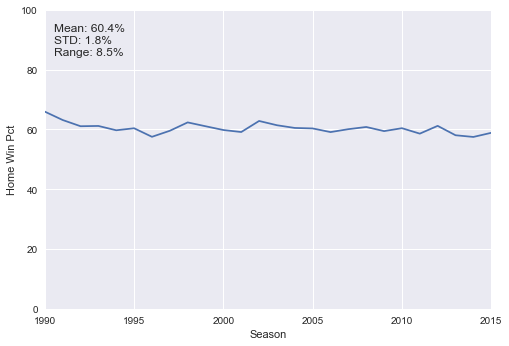

In [6]:
pct = data.HomeWinPct
plt.plot(data.SEASON, pct)
plt.text(1990.5, 85,
         'Mean: {0:.1f}%\nSTD: {1:.1f}%\nRange: {2:.1f}%'
         .format(np.mean(pct), np.std(pct), np.ptp(pct)))
plt.xlabel('Season')
plt.ylabel('Home Win Pct')
plt.xlim(1990, 2015)
plt.ylim(0, 100)
plt.show()

Now let's calculate some advanced stats from the basic box score data. The code below returns a Pandas DataFrame with team offensive and defensive ratings (points scored/allowed per 100 possessions) averaged across each season, as well as SRS.

In [7]:
database = Database('../nba.db')
season_stats = database.season_stats()

The histogram and KDE of team SRS below show that teams are fairly normally distributed. The best fit normal distribution has a mean of essentially zero with a standard deviation of about 4.6 points. A zero-mean distribution makes sense here because an SRS of zero indicates a perfectly average team.

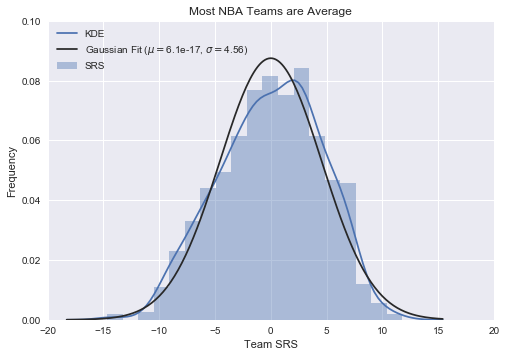

In [8]:
srs = season_stats['TEAM_SRS']
(mu, sigma) = norm.fit(srs)
ax = sns.distplot(srs, fit=norm, kde=True, kde_kws={'label': 'KDE'}, hist_kws={'label': 'SRS'},
                  fit_kws={'label': 'Gaussian Fit ($\mu=${0:.2g}, $\sigma=${1:.2f})'.format(mu, sigma)})
ax.legend(loc='best')
plt.xlim(-20, 20)
plt.ylim(0, 0.1)
plt.xlabel('Team SRS')
plt.ylabel('Frequency')
plt.title('Most NBA Teams are Average')
sns.plt.show()

The next step is to look at games in terms of home and away team stats.

In [9]:
seasons = season_stats.filter(regex='SEASON|TEAM')
games = pd.read_sql('SELECT * FROM games', conn)
games = games.merge(seasons, left_on=['SEASON', 'HOME_TEAM_ID'], right_on=['SEASON', 'TEAM_ID'])
games = games.merge(seasons, left_on=['SEASON', 'AWAY_TEAM_ID'], right_on=['SEASON', 'TEAM_ID'],
                    suffixes=('', '_OPP'))

The plot below shows a 2D KDE that compares home and away team SRS. By inspection, the majority of games occur between teams with SRS values within 5 points of average. This makes intuitive sense given the standard deviation of 4.6 points calculated above. Assuming the Gaussian distribution above, more than 68% of all teams since 1990 have SRS values with a magnitude less than 5 based on the definition of a normal distribution. The distribution appears symmetric about a y=x line because under normal circumstances (each team plays a full season), teams have the same number of home and away games. 

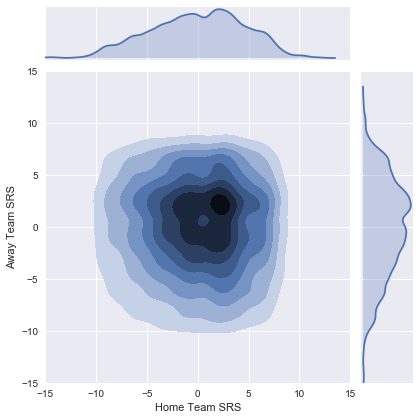

In [10]:
ax = sns.jointplot(x='TEAM_SRS', y='TEAM_SRS_OPP', data=games, kind='kde',
                   shade_lowest=False, stat_func=None, xlim=(-15, 15), ylim=(-15, 15))
ax.set_axis_labels(xlabel='Home Team SRS', ylabel='Away Team SRS')
plt.show()

A better view of this data is to separate games into home team wins and losses. The plots below show KDE plots of SRS for home team wins and losses with a red point added to easily identify the origin. The high-density area towards the lower right of the orgin for home team wins (left plot) indicates there are many games in the dataset where above-average home teams beat below-average away teams, which is not a surprising revelation. We draw the opposite conclusion for home team losses. The highest density occurs towards the upper left of the orgin, meaning games where a below-average home team plays an above-average visiting teams typically does not go well for the home team. There is also a small cluster of games in the left plot where above-average home teams beat above-average visitors of roughly equal quality. This may be caused by home court advantage, but was not investigated further.

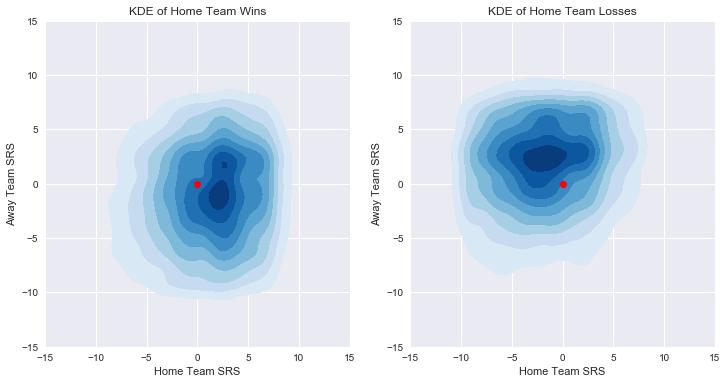

In [11]:
plt.figure(figsize=(12, 6))

def kde(data, ax, title):
    sns.kdeplot(data.TEAM_SRS, data.TEAM_SRS_OPP, cmap='Blues', shade=True, shade_lowest=False, ax=ax)
    ax.plot(0, 0, 'or')
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_xlabel('Home Team SRS')
    ax.set_ylabel('Away Team SRS')
    ax.set_title(title)

# Find games where the home team won
kde(games[games.HOME_WL=='W'], plt.subplot(121), 'KDE of Home Team Wins')

# Find games where the home team lost
kde(games[games.HOME_WL=='L'], plt.subplot(122), 'KDE of Home Team Losses')

plt.show()

The plots below repeat those above for team net ratings (offensive rating - defensive rating). They illustrate that the same trends hold true for net ratings as did for SRS above.

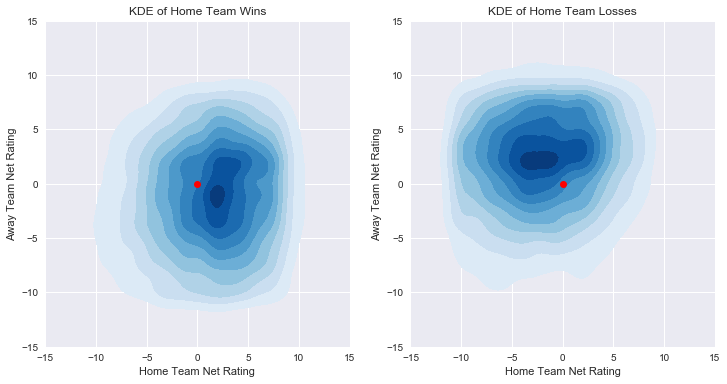

In [12]:
plt.figure(figsize=(12, 6))

def kde(data, ax, title):
    sns.kdeplot(data.TEAM_OFF_RTG - data.TEAM_DEF_RTG, data.TEAM_OFF_RTG_OPP - data.TEAM_DEF_RTG_OPP,
                cmap='Blues', shade=True, shade_lowest=False, ax=ax)
    ax.plot(0, 0, 'or')
    ax.set_xlim(-15, 15)
    ax.set_ylim(-15, 15)
    ax.set_xlabel('Home Team Net Rating')
    ax.set_ylabel('Away Team Net Rating')
    ax.set_title(title)
    

# Find games where the home team won
kde(games[games.HOME_WL=='W'], plt.subplot(121), 'KDE of Home Team Wins')

# Find games where the home team lost
kde(games[games.HOME_WL=='L'], plt.subplot(122), 'KDE of Home Team Losses')

plt.show()